# 데이터 증강 파이프라인

실제로 딥러닝 프로젝트를 진행하면 가장 중요한 것은 학습 데이터입니다.<br>
학습 데이터는 학습 모델의 성능에 가장 큰 영향을 미치기 때문입니다. 하지만 양질의 대규모 데이터를 얻는 것은 많은 시간과 비용을 필요로 합니다. <br>
때문에 적은 양의 데이터로도 좋은 성능을 가지는 모델을 얻기 위하여 데이터 증강 기법을 도입합니다.
<br><br>
본 예제에서는 파이프라인 작성 예시를 실제로 어떻게 사용하는지를 확인합니다. 예제에 필요한 데이터는 tensorflow datasets에서 제공하는 beans 데이터를 사용합니다. <br>
> 본 예제를 실행하기 위해서는 tensorflow, tensorflow-datasets, matplotlib 패키지가 필요합니다.

In [7]:
import tensorflow_datasets as tfds

ds, ds_info = tfds.load('beans', split='train', shuffle_files=True, with_info=True)

2022-09-21 15:10:16.689319: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/beans/0.1.0.incompleteHKEMCB/beans-train.tfrecord*...:   0%|          | 0/1034…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/beans/0.1.0.incompleteHKEMCB/beans-validation.tfrecord*...:   0%|          | 0…

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/beans/0.1.0.incompleteHKEMCB/beans-test.tfrecord*...:   0%|          | 0/128 […

Dataset beans downloaded and prepared to ~/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


2022-09-21 15:11:40.304492: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


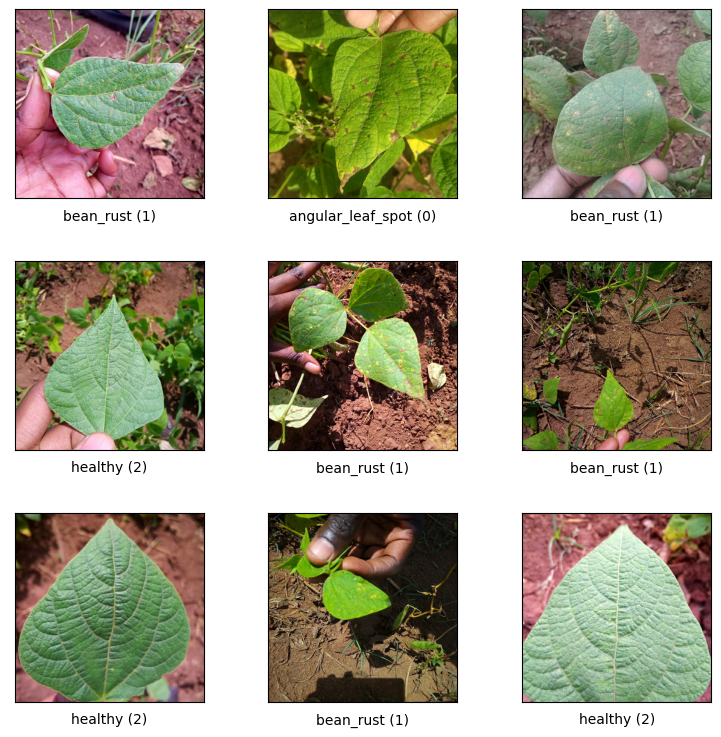

In [11]:
fig = tfds.show_examples(ds, ds_info)

In [15]:
print(f'데이터 크기 : {ds_info.splits["train"].num_examples}')
print(f'이미지 크기 : {ds_info.features["image"].shape}')

데이터 크기 : 1034
이미지 크기 : (500, 500, 3)


beans dataset을 활용하여 1034개의 데이터를 증강합니다. 본 예제에서는 이미지 반전 및 회전을 적용합니다.

## 데이터 로드 컴포넌트

데이터 증강을 하기 전에 데이터를 불러오는 컴포넌트를 작성합니다.

In [16]:
from kfp import components, dsl
from kfp.components import InputPath, OutputPath
import kfp

본 예제에서는 데이터를 입력과 출력으로 받기 때문에 기존 간단한 인수가 아닌 InputPaht, OutputPath를 사용합니다.

In [17]:
def train_data_load(
        output_dataset_train_data: OutputPath('Dataset')
):
    import tensorflow as tf
    import pandas as pd
    import pickle
    import tensorflow_datasets as tfds

    ds, ds_info = tfds.load('beans', split='train', shuffle_files=True, with_info=True)

    df = pd.DataFrame(columns=['image', 'label'])
    for i, image in enumerate(ds):
        df.loc[i] = ({'image': image['image'], 'label': image['label']})

    with open(output_dataset_train_data, 'wb') as f:
        pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)


train_data_load_op = components.create_component_from_func(
    train_data_load, base_image='tensorflow/tensorflow',
    packages_to_install=['pandas==1.4.2', 'tensorflow-datasets'])

데이터를 불러오는데 필요한 패키지들을 추가적으로 설정합니다. kubeflow에서 입력과 출력을 파일 형태로 전달하기 때문에 본 예제에서는 pickle 형태의 데이터로 변환하여 활용합니다.

## 이미지 반전

이미지를 왼쪽 오른쪽으로 뒤집어서 데이터를 증강합니다. tensorflow에서 제공하는 image 모듈을 사용합니다.

In [18]:
def flip_left_right(
        pre_data:InputPath('Dataset'),
        data: OutputPath('Dataset')
):
    import tensorflow as tf
    import numpy as np
    import pickle
    import pandas as pd

    images = []
    labels = []
    with open(pre_data, 'rb') as file:
        tr_data = pickle.load(file)

    for i, item in enumerate(tr_data['image']):
        images.append(item)
        labels.append(tr_data['label'][i])
    images = np.array(images)
    labels = np.array(labels)

    new_image = []
    new_label = []
    for i, image in enumerate(images):
        result = tf.image.flip_left_right(image)
        new_image.append(result)
        new_label.append(labels[i])

    df = pd.DataFrame(columns=['image', 'label'])

    for i, image in enumerate(new_image):
        df.loc[i] = ({'image': image, 'label': new_label[i]})
    with open(data, 'wb') as f:
        pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)


flip_left_right_op = components.create_component_from_func(
    flip_left_right, base_image='tensorflow/tensorflow',
    packages_to_install=['pandas==1.4.2', 'numpy'])

## 이미지 회전

이미지 회전도 tensorflow의 image를 사용합니다.

In [19]:
def rotation(
        pre_data:InputPath('Dataset'),
        data: OutputPath('Dataset')
):
    import tensorflow as tf
    import numpy as np
    import pickle
    import pandas as pd

    images = []
    labels = []
    with open(pre_data, 'rb') as file:
        tr_data = pickle.load(file)

    for i, item in enumerate(tr_data['image']):
        images.append(item)
        labels.append(tr_data['label'][i])
    images = np.array(images)
    labels = np.array(labels)

    new_image = []
    new_label = []
    for i, image in enumerate(images):
        result = tf.image.rot90(image)
        new_image.append(result)
        new_label.append(labels[i])


    df = pd.DataFrame(columns=['image', 'label'])

    for i, image in enumerate(new_image):
        df.loc[i] = ({'image': image, 'label': new_label[i]})
    with open(data, 'wb') as f:
        pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)


rotation_op = components.create_component_from_func(
    rotation, base_image='tensorflow/tensorflow',
    packages_to_install=['pandas==1.4.2', 'numpy'])

## 데이터 병합

기존의 데이터에 이미지 반전과 회전을 적용한 데이터를 추가합니다. 이때, 기존에 사용했던 파이프라인 구조를 적용합니다.
<br>노드 4개로 구성하는 예제에서 기존 데이터를 마지막 병합에 활용하기 때문에 마지막 노드에 입력을 수정하여 추가적인 연결을 구성합니다.

In [20]:
def merge_data_generation(
        origin_data:InputPath('Dataset'),
        re_data:InputPath('Dataset'),
        ho_data:InputPath('Dataset'),
        data: OutputPath('Dataset')
):
    import numpy as np
    import pickle
    import pandas as pd

    with open(origin_data, 'rb') as file:
        data_1 = pickle.load(file)
    with open(re_data, 'rb') as file:
        data_2 = pickle.load(file)
    with open(ho_data, 'rb') as file:
        data_3 = pickle.load(file)

    result_temp = pd.concat([data_1,data_2], ignore_index=True)
    result = pd.concat([result_temp,data_3], ignore_index=True)

    with open(data, 'wb') as f:
        pickle.dump(result, f, pickle.HIGHEST_PROTOCOL)

merge_data_generation_op = components.create_component_from_func(
    merge_data_generation, base_image='tensorflow/tensorflow',
    packages_to_install=['pandas==1.4.2', 'numpy'])

# 파이프라인 구성

모든 컴포넌트 작성을 완료하였습니다. 이제 컴포넌트들을 연결하여 파이프라인을 작성합니다. <br>
먼저 데이터셋을 불러옵니다. 불러온 데이터는 증강을 위해 증강 컴포넌트에 입력합니다. 입력 후 마지막으로 데이터 병합을 위하여 증강 데이터를 마지막 노드에 입력합니다.<br>
이때, 기존 데이터도 필요하기 때문에 처음 노드를 마지막 노드에 연결하여 모든 데이터 병합 작업을 진행하여 워크플로우를 구성합니다.

In [21]:
@dsl.pipeline(name='tensorflow beans dataset augmentation pipeline example')
def beans_data_augmentation_pipeline():
    train_data_load_task = train_data_load_op()


    resize_and_rescale_task = flip_left_right_op(
        train_data_load_task.outputs['output_dataset_train_data']
    )
    horizontal_and_vertical_task = rotation_op(
        train_data_load_task.outputs['output_dataset_train_data']
    )


    merge_data_generation_task = merge_data_generation_op(
        train_data_load_task.outputs['output_dataset_train_data'],
        resize_and_rescale_task.outputs['data'],
        horizontal_and_vertical_task.outputs['data']
    )


## 파이프라인 결과 화면

<img src='beans_result.png' width='750px'></img>

이처럼 실제 파이프라인 연결 예제를 데이터 증강에서 사용할 수 있습니다.